<a href="https://colab.research.google.com/github/z27833009/Deep_Learning_4_NLP_Homework/blob/main/Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Note for the homework: You can add further images or comments in the submitted PDF file if you don't want to do it here.

from google.colab import drive
drive.mount('/content/drive')

# path to store the data
%cd /content/drive/My Drive/dl4nlp_2023/

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/My Drive/dl4nlp_2023/'
/content


In [ ]:
# Run this cell to intall/import all denpendicies needed for this homework; you can also add arbitrary libararies.

!pip install datasets
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from scipy.stats import pearsonr, kendalltau
from pprint import pprint
import matplotlib.pyplot as plt
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# This function is used to specify the random seeds that could impact pytorch.

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# **Task 1: Getting to Know Pytorch: Semantic Textual Similarity**

In this task, we define semantic textual similarity (STS) as a **supervised** regression task in which the semantic similarity of two pieces of text (typically sentences) should be determined.

### **Task 1.1: Data Preparation**

**Run the following cell to load the dataset for this task first**. Each entry of this dataset contains one English sentence pair and their similarity score.

To get familiar with the data format, please **print** the first entry of `train_set`, the size of `dev_set`, and the first 3 `sentence1` in `train_set`.

**Hint**: the data is structured like both Python dictionary and Pandas DataFrame.



In [ ]:
train_set = load_dataset("stsb_multi_mt", "en", split='train')
dev_set = load_dataset("stsb_multi_mt", "en", split='dev')

dev_set

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 1500
})

In [ ]:
# TODO: YOUR CODE HERE
print(train_set[0])
print(len(dev_set))

print(train_set[0:3]["sentence1"])

{'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'similarity_score': 5.0}
1500
['A plane is taking off.', 'A man is playing a large flute.', 'A man is spreading shreded cheese on a pizza.']


## **Task 1.1.1: Embed the sentences**
We will use the averages of the words' [FastText embeddings](https://dl.fbaipublicfiles.com/fasttext) to embed both sentences.

**Run the following cell to download the embeddings.**

In [ ]:
# download word emebddings to your drive and unzip the file (run this cell only when you haven't downloaded the emb file yet.)
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2023-05-29 15:39:05--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.59, 13.227.219.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   224MB/s    in 2.9s    

2023-05-29 15:39:09 (224 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


### a)
Implement a funtion to read the word embeddings into a Python dictionary that maps every token to the corresponding vector. Represent the vectors as Numpy arrays. Only load the embeddings of the first 40,000 tokens in the file.

**Print** the size of the dictionary and the first 20 dimensions of the embedding for word "homework".

In [ ]:
from pyarrow import float32
import numpy as np
import io

def load_embeddings(file="wiki-news-300d-1M.vec"):
    fin = io.open(file, 'r', encoding='utf-8', newline='\n', errors='ignore')
    num_word, vec_dim = map(int, fin.readline().split())
    #print(num_word, vec_dim)
    data = {}
    count = 0
    for line in fin:
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        vector = np.array(tokens[1:], dtype="float32")
        data[word] = vector
        count += 1
        if count >= 40000:
            break
    fin.close()
    return data
embeddings = load_embeddings()
print("Dictionary size:", len(embeddings))
print("Embedding dimensions for 'homework':", embeddings['homework'][:20])
# print("type:", type(embeddings['homework']))

Dictionary size: 40000
Embedding dimensions for 'homework': [-0.1756  0.0695  0.0847  0.0988 -0.1196 -0.1389 -0.0379  0.0543  0.1022
 -0.0082 -0.0488 -0.1748 -0.0181 -0.131  -0.1794  0.2143 -0.1612 -0.113
  0.0213 -0.0763]


### b)
Implement a function that tokenizes a sentence using [nltk.word_tokenize](https://www.nltk.org/book/ch03.html#accessing-text-from-the-web-and-from-disk) and returns a list of tokens for given sentence.

**Print** the tokenized sentence1 and sentence2 of the first entry in the training set.

In [ ]:
def tokenize(sentence):
  # TODO: YOUR CODE HERE
  return nltk.word_tokenize(sentence)

print(tokenize(train_set[0]["sentence1"]))
print(tokenize(train_set[0]["sentence2"]))


['A', 'plane', 'is', 'taking', 'off', '.']
['An', 'air', 'plane', 'is', 'taking', 'off', '.']


### c)
Implement a function that maps a sentence to its embedding. The sentence-level embedding should be the average of the embeddings of its tokens. If a token does not exist in the vocabulary of FastText, embed this token as a 0-vector with the same dimensions as the FastText embeddings.

**Print** the shape and the first 20 dimensions of sentence1's embedding of the first entry in the training set.


In [ ]:
from ast import Return
def embed_sentence(sentence, word2emb):
  # TODO: YOUR CODE HERE
  tokenized_sen = tokenize(sentence)
  embed_vec_list = []
  for token in tokenized_sen:
    if(token in word2emb):
      embed_vec_list.append(word2emb[token])
    else:
      embed_vec_list.append(np.zeros(300))
  return np.average(embed_vec_list, axis=0)

print(embed_sentence(train_set[0]["sentence1"],embeddings)[:20])

[ 0.01895     0.01555    -0.03663334  0.04301667 -0.05261667 -0.043
 -0.05235    -0.02503333 -0.01348333 -0.02275     0.023      -0.00196667
  0.01398333 -0.01931667  0.04275     0.02686667 -0.00416667  0.05871667
 -0.06091667  0.0174    ]


## **Task 1.1.2: Build Custom Dataset**


### a)
Implement a custom dataset class inheriting [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) and override the following methods:
- `__len__`: which returns the size of the dataset.
- `__getitem__`: to support the indexing such that dataset[i] can be used to get `ith` sample.

The `ith` sample should be a Python dict with two entries:
- `encoding` the encoding of one sentence pair, which is the concatenation of the embeddings of the two sentences of a pair. E.g., sent1 = [1,2], sent2 = [3,4], the encoding for sent1 and sent2 should be [1,2,3,4].
- `score` the similarity score between the two sentences.

**Hint**: examples can be found here: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
class MLPDataset(Dataset):
  def __init__(self, sents_1, sents_2, scores):
    """
    Arguments:
      sents_1 (List[string]): the list of the first sentences.
      sents_2 (List[string]): the list of the second sentences.
      scores (List[float]): the list of the similarity scores.
    """
    self.sents_1 = sents_1
    self.sents_2 = sents_2
    self.scores = scores


  def __getitem__(self, idx):
    sent1 = embed_sentence(self.sents_1[idx], embeddings)
    sent2 = embed_sentence(self.sents_2[idx], embeddings)
    encoding = np.concatenate([sent1, sent2])
    score = self.scores[idx]
    return {'encoding': encoding, 'score': score}

  def __len__(self):
    return len(self.sents_1)


### b)
Instantiate the above class for our `train_set` and `dev_set`.

**Print** the size of `dev_dataset` and the shape of the encoding of the first example.

In [ ]:
# TODO: YOUR CODE HERE
train_dataset = MLPDataset([entry["sentence1"] for entry in train_set], [entry["sentence2"] for entry in train_set], [entry["similarity_score"] for entry in train_set])
dev_dataset = MLPDataset([entry["sentence1"] for entry in dev_set], [entry["sentence2"] for entry in dev_set], [entry["similarity_score"] for entry in dev_set])

print(f"size of dev_dataset: {len(dev_dataset)}")
print(f"shape of the encoding of the first example: {dev_dataset[0]['encoding'].shape}")

size of dev_dataset: 1500
shape of the encoding of the first example: (600,)


## **Task 1.2: Scoring the Similarity**
We will train a simple multi-layer perceptron (MLP) to score the similarity of the two sentences. The MLP should concatenate both inputs and have two hidden layers with dropout. The first hidden layer should have 300 dimensions and ReLU activation, and the second hidden layer (the output layer) should have 1 dimension and sigmoid activation.

The precise definition is as follows:
- Two inputs, one for each sentence embedding.
Hint: As we use two sentence, youca

### **Task 1.2.1: Build MLP using Pytorch**

We will use [`pytorch.nn`](https://pytorch.org/docs/stable/nn.html) to build our MLP.

Implement a class inheriting [`pytorch.nn.Module`]() for our MLP, which has the following components:
- A [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) with 1,200 dimensions and [relu activation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) , which takes the encoding of one sentence pair as the input.
- A [dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) with probability 0.1.
- A linear layer with 600 dimensions and relu activation.
- A dropout layer with probability 0.1.
- A linear layer with 300 dimensions and relu activation.
- A dropout layer with probability 0.1.
- A linear layer with 1 dimension (output layer).

**Hint**:
- You need to override the method `forward` in this class
- Use `nn.Sequential` to sequentialize the layers.
- You may want to see a quick example: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html?highlight=sequential


In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(600, 1200),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.Linear(1200, 600),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.Linear(600, 300),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.Linear(300, 1)
  )

  def forward(self, x):
    return self.layers(x)

model = MLP()
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=600, out_features=1200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1200, out_features=600, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=600, out_features=300, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=300, out_features=1, bias=True)
  )
)


### **Task 1.2.2: Train MLP with Pytorch**
Train the MLP with the following setups/hyperparameters:
- [AdmW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#torch.optim.AdamW) with a learning rate of 2e-3 as the  optimizer
- [Mean Square Error](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) as the loss function
- batch size: 128
- number of training epochs: 17


### a)
The method for training is provided below, which returns the list of the train loss at all epochs and the trained model. Please define the corresponding parameters to call this method and **plot** the training loss using `matplotlib.pyplot.plot`; with GPU the training takes about 1.5 mins for 17 epochs.

**Hint**: create the dataloader for the custom datasets (`train_dataset` and `dev_dataset`) using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader); reshuffle the training data at every epoch (don't forget to define the batch size for the dataloader!).



In [ ]:
def train(model, train_dataloader, eval_dataloader, optimizer, loss_fn, num_epochs, device='cuda'):

  train_losses = []

  for epoch in range(num_epochs):

    if epoch == 0:
      model.eval()
      loss_per_epoch = 0
      for batch_data in train_dataloader:
        with torch.no_grad():
          predictions = model(batch_data['encoding'].to(device))
          targets = batch_data['score'].to(device) # only if device='cuda'
          train_loss = loss_func(predictions.squeeze(), targets)
          loss_per_epoch += train_loss.item()
      loss_per_epoch = loss_per_epoch/len(train_dataloader)
      train_losses.append(loss_per_epoch)
      print(f'\ninital train loss: {loss_per_epoch}')

    model.train()
    loss_per_epoch = 0
    for batch_data in train_dataloader:
      predictions = model(batch_data['encoding'].to(device))
      targets = batch_data['score'].to(device) # only if device='cuda'
      train_loss = loss_func(predictions.squeeze(), targets)
      loss_per_epoch += train_loss.item()

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

    loss_per_epoch = loss_per_epoch/len(train_dataloader)
    train_losses.append(loss_per_epoch)
    print(f'\n Epoch {epoch+1} train loss: {loss_per_epoch}')
    #evaluate(model, eval_dataloader, loss_func)

  return train_losses, model




inital train loss: 9.52442288001194

 Epoch 1 train loss: 2.8500087570112367

 Epoch 2 train loss: 1.9586442461437905

 Epoch 3 train loss: 1.8708696411369623

 Epoch 4 train loss: 1.750495061392061

 Epoch 5 train loss: 1.572920981330458

 Epoch 6 train loss: 1.3920534092515118

 Epoch 7 train loss: 1.249560242487697

 Epoch 8 train loss: 1.1129921466124324

 Epoch 9 train loss: 0.8885104894405131

 Epoch 10 train loss: 0.7828529275467949

 Epoch 11 train loss: 0.6609892731886652

 Epoch 12 train loss: 0.6042303329781513

 Epoch 13 train loss: 0.47833828456561817

 Epoch 14 train loss: 0.4461021848084567

 Epoch 15 train loss: 0.39090712506783326

 Epoch 16 train loss: 0.36073848151021143

 Epoch 17 train loss: 0.3265256619823978


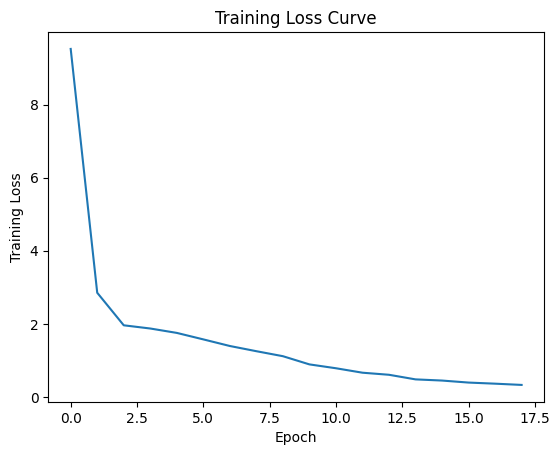

In [ ]:
torch.set_default_tensor_type(torch.DoubleTensor)

# Set random seeds; do not change this!
seed_everything(seed=999)

# Define the training hyperparameters
num_epochs = 17
batch_size = 128
learning_rate = 2e-3

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP()
model.to(device)


# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_func = torch.nn.MSELoss()

# Train the model
train_losses, trained_model = train(model, train_dataloader, dev_dataloader, optimizer, loss_func, num_epochs, device)

# Plot the training losses
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()


### b)
Implement a method to evaluate a model which calculates the Pearson correlation between the predictions of the model and the similarity scores from the dataset.

**Print** the evaluation results  of your trained model on the dev set.

In [ ]:
import numpy as np
from scipy.stats import pearsonr

def evaluate(model, eval_dataloader, loss_func):
    model.eval()  # Set the model in evaluation mode

    predictions = []
    targets = []

    with torch.no_grad():
        for batch_data in eval_dataloader:
            batch_encoding = batch_data['encoding'].to(device)
            batch_targets = batch_data['score'].to(device)

            batch_predictions = model(batch_encoding).squeeze()
            predictions.extend(batch_predictions.cpu().numpy())
            targets.extend(batch_targets.cpu().numpy())

    predictions = np.array(predictions)
    targets = np.array(targets)

    correlation, _ = pearsonr(predictions, targets)
    return correlation

evaluation_result = evaluate(trained_model, dev_dataloader, loss_func)
print("Evaluation Result (Pearson correlation):", evaluation_result)


Evaluation Result (Pearson correlation): 0.4353980508854822
